# 1. Inputs

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ["KERAS_BACKEND"] = "tensorflow"

from sklearn.model_selection import train_test_split

import keras
from keras.applications import MobileNet, MobileNetV2, ResNet50
from keras.models import load_model

%matplotlib inline

import tensorflow as tf

# 2. Constant definitions

In [2]:
DATASET_PATH = os.path.join("/", "kaggle", "input", "marketplace-navigation-dataset", "dataset")
DRONET_PATH = os.path.join("/", "kaggle", "input", "marketplace-navigation-dataset", "model.keras")

# 3. Utilities

## 3.1 Method that loads the dataset

In [3]:
import cv2 as cv
from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count

def load_dataset(dataset_path: str, image_size=(224, 224), grayscale=False):
    data = pd.read_csv(os.path.join(DATASET_PATH, "market_dataset_xy.txt"), sep=" ", header=None)

    file_names = data[0].to_list()
    image_paths = [os.path.join(DATASET_PATH, "images", file_name) for file_name in file_names]
    
    if not os.path.exists("cache"):
        os.mkdir("cache")

    cache_path = f"images_{image_size[0]}x{image_size[1]}"
    if grayscale:
        cache_path += "_grayscale"
    cache_path += ".npy"
    cache_path = os.path.join("cache", cache_path)

    if os.path.exists(cache_path):
        print("[LOG] loading images from cache at", cache_path)
        X = np.load(cache_path)
        y = data[[4, 3]].to_numpy()

        return X, y
        
    else:
        def load_image(image_path: str):
            if grayscale:
                image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            else:
                image = cv.imread(image_path)
                
            image = cv.resize(image, image_size, interpolation=cv.INTER_LINEAR)
            image = image / 255.0
            
            return image

        X = np.array([load_image(image_path) for image_path in tqdm(image_paths)])
        y = data[[4, 3]].to_numpy()
        
        print("[LOG] Caching images to", cache_path)
        np.save(cache_path, X)
        if np.allclose(np.load(cache_path), X):
            print("[LOG] Cache successful!")
        
        return X, y

## 3.2 Data generator definition

In [4]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        return np.array([self.X[i] for i in batch_indexes]), np.array([self.y[i] for i in batch_indexes])

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

## 3.3 Model creation methods

In [5]:
def create_resnet50():
    # ResNet50 creation
    inputs = keras.layers.Input(shape=(224, 224, 3))
    
    base = keras.applications.ResNet50(
        name="resnet_cnn_layers",
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="max"
    )
    base.trainable = False
    
    x = base(inputs)
    
    x = keras.layers.Flatten(name="resnet_flatten")(x)
    x = keras.layers.Dense(1024, activation="relu", name="resnet_dense_1")(x)
    x = keras.layers.Dense(1024, activation="relu", name="resnet_dense_2")(x)
    
    outputs = keras.layers.Dense(1, activation="linear", name="resnet_output")(x)

    model = keras.Model(name="resnet_50", inputs=inputs, outputs=outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    return model

def create_MobileNet():
    inputs = keras.layers.Input(name="MobileNet_input", shape=(224, 224, 3))
    
    base = keras.applications.MobileNet(
        name="MobileNet_cnn_layers",
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="max"
    )
    base.trainable = False
    
    x = base(inputs)
    
    x = keras.layers.Flatten(name="MobileNet_flatten")(x)
    x = keras.layers.Dense(1024, activation="relu", name="MobileNet_dense_1")(x)
    x = keras.layers.Dense(1024, activation="relu", name="MobileNet_dense_2")(x)
    
    outputs = keras.layers.Dense(1, activation="linear", name="MobileNet_output")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="MobileNet")
    
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    return model

def create_MobileNetV2():
    inputs = keras.layers.Input(name="MobileNetV2_input", shape=(224, 224, 3))
    
    base = keras.applications.MobileNetV2(
        name="MobileNetV2_cnn_layers",
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="max"
    )
    base.trainable = False
    
    x = base(inputs)
    
    x = keras.layers.Flatten(name="MobileNetV2_flatten")(x)
    x = keras.layers.Dense(1024, activation="relu", name="MobileNetV2_dense_1")(x)
    x = keras.layers.Dense(1024, activation="relu", name="MobileNetV2_dense_2")(x)
    
    outputs = keras.layers.Dense(1, activation="linear", name="MobileNeV2_output")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="MobileNetV2")
    
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    return model

def create_dronet():
    base = keras.models.load_model(DRONET_PATH)
    base.name = "Dronet_cnn_layers"
    base.trainable = False
    
    inputs = base.input
    conv_layers = base.output
    
    # All three layers are specified in a ilustration found in the original article
    x = keras.layers.Flatten(name="Dronet_flatten")(conv_layers)
    x = keras.layers.ReLU(name="Dronet_relu")(x)
    x = keras.layers.Dropout(0.3, name="Dronet_dropout")(x)
    
    x = keras.layers.Dense(1024, activation="relu", name="Dronet_dense_1")(x)
    x = keras.layers.Dense(1024, activation="relu", name="Dronet_dense_2")(x)
    
    outputs = keras.layers.Dense(1, activation="linear", name="Dronet_output")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="Dronet")
    
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

    return model

# 4. Benchmark of each model for horizontal speed

In [6]:
def train_model(model, train_dataset, validation_dataset):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=200,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_mae", patience=20, min_delta=0.001),
            keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=5, min_lr=1e-7)
        ]
    )

    return model, history

In [7]:
def evaluate_x_axis_results(model, dataset_path):
    IMAGE_WIDTH, IMAGE_HEIGHT, channels = model.input.shape[1:]

    grayscale = channels == 1
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    
    X, y = load_dataset(dataset_path, image_size=image_size, grayscale=grayscale)
    y = y[:, 0].ravel()

    y_binned = pd.qcut(y, q=10, labels=False)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        train_size=0.6,
        shuffle=True,
        random_state=0,
        stratify=y_binned
    )

    y_temp_binned = pd.qcut(y_temp, q=10, labels=False)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        train_size=0.5,
        shuffle=True,
        random_state=0,
        stratify=y_temp_binned
    )
    
    train_dataset = DataGenerator(X_train, y_train)
    validation_dataset = DataGenerator(X_val, y_val)

    model, history = train_model(model, train_dataset, validation_dataset)

    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    test_mse, test_mae = model.evaluate(X_test, y_test, batch_size=len(X_test))
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    
    # Train vs Validation MSE
    ax[0, 0].set_title("Train vs Validation MSE")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Mean Squared Error")
    ax[0, 0].plot(history.history["loss"], label="Train")
    ax[0, 0].plot(history.history["val_loss"], label="Validation")
    ax[0, 0].legend()
    
    # Add Test MSE as text
    ax[0, 0].text(0.5, 0.7, f"Test MSE: {test_mse:.4f}", 
                  transform=ax[0, 0].transAxes, fontsize=10, color="black")
    
    # Train vs Validation MAE
    ax[0, 1].set_title("Train vs Validation MAE")
    ax[0, 1].set_xlabel("Epochs")
    ax[0, 1].set_ylabel("Mean Absolute Error")
    ax[0, 1].plot(history.history["mae"], label="Train")
    ax[0, 1].plot(history.history["val_mae"], label="Validation")
    ax[0, 1].legend()
    
    # Add Test MAE as text
    ax[0, 1].text(0.5, 0.7, f"Test MAE: {test_mae:.4f}", 
                  transform=ax[0, 1].transAxes, fontsize=10, color="black")
    
    # Test Scatter Plot
    ax[1, 0].set_title(model.name + " Test Scatter")
    ax[1, 0].set_xlabel("Actual Values")
    ax[1, 0].set_ylabel("Predicted Values")
    ax[1, 0].scatter(y_test, y_test_pred, alpha=0.6)
    
    # Validation Scatter Plot
    ax[1, 1].set_title(model.name + " Validation Scatter")
    ax[1, 1].set_xlabel("Actual Values")
    ax[1, 1].set_ylabel("Predicted Values")
    ax[1, 1].scatter(y_val, y_val_pred, alpha=0.6)
    
    plt.tight_layout()

In [8]:
def evaluate_y_axis_results(model, dataset_path):
    IMAGE_WIDTH, IMAGE_HEIGHT, channels = model.input.shape[1:]

    grayscale = channels == 1
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    
    X, y = load_dataset(dataset_path, image_size=image_size, grayscale=grayscale)
    y = y[:, 1].ravel()
    
    y_binned = pd.qcut(y, q=10, labels=False)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        train_size=0.6,
        shuffle=True,
        random_state=0,
        stratify=y_binned
    )

    y_temp_binned = pd.qcut(y_temp, q=10, labels=False)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        train_size=0.5,
        shuffle=True,
        random_state=0,
        stratify=y_temp_binned
    )
    
    train_dataset = DataGenerator(X_train, y_train)
    validation_dataset = DataGenerator(X_val, y_val)

    model, history = train_model(model, train_dataset, validation_dataset)

    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    test_mse, test_mae = model.evaluate(X_test, y_test, batch_size=len(X_test))
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    
    # Train vs Validation MSE
    ax[0, 0].set_title("Train vs Validation MSE")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Mean Squared Error")
    ax[0, 0].plot(history.history["loss"], label="Train")
    ax[0, 0].plot(history.history["val_loss"], label="Validation")
    ax[0, 0].legend()
    
    # Add Test MSE as text
    ax[0, 0].text(0.5, 0.7, f"Test MSE: {test_mse:.4f}", 
                  transform=ax[0, 0].transAxes, fontsize=10, color="black")
    
    # Train vs Validation MAE
    ax[0, 1].set_title("Train vs Validation MAE")
    ax[0, 1].set_xlabel("Epochs")
    ax[0, 1].set_ylabel("Mean Absolute Error")
    ax[0, 1].plot(history.history["mae"], label="Train")
    ax[0, 1].plot(history.history["val_mae"], label="Validation")
    ax[0, 1].legend()
    
    # Add Test MAE as text
    ax[0, 1].text(0.5, 0.7, f"Test MAE: {test_mae:.4f}", 
                  transform=ax[0, 1].transAxes, fontsize=10, color="black")
    
    # Test Scatter Plot
    ax[1, 0].set_title(model.name + " Test Scatter")
    ax[1, 0].set_xlabel("Actual Values")
    ax[1, 0].set_ylabel("Predicted Values")
    ax[1, 0].scatter(y_test, y_test_pred, alpha=0.6)
    
    # Validation Scatter Plot
    ax[1, 1].set_title(model.name + " Validation Scatter")
    ax[1, 1].set_xlabel("Actual Values")
    ax[1, 1].set_ylabel("Predicted Values")
    ax[1, 1].scatter(y_val, y_val_pred, alpha=0.6)
    
    plt.tight_layout()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


  0%|          | 0/2270 [00:00<?, ?it/s]

[LOG] Caching images to cache/images_224x224.npy
[LOG] Cache successful!
Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - loss: 1.1061 - mae: 0.8252 - val_loss: 0.5035 - val_mae: 0.4609 - learning_rate: 1.0000e-04
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.4246 - mae: 0.3735 - val_loss: 0.4335 - val_mae: 0.3319 - learning_rate: 1.0000e-04
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.4601 - mae: 0.3974 - val_loss: 0.4498 - val_mae: 0.3960 - learning_rate: 1.0000e-04
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.3878 - mae: 0.3484 - val_loss: 0.6712 - val_mae: 0.6556 - learning_rate: 1.0000e-04
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.4390 - mae: 0.4357 - val_loss: 0.3633 - val_mae: 0.3300 - learning_rate: 1.0000e-04
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.4181 - mae: 0.4012 - val_loss: 0.3906 - val_mae: 0.4083 - learning_rate: 1.0000e-04
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/st

  0%|          | 0/2270 [00:00<?, ?it/s]

[LOG] Caching images to cache/images_200x200_grayscale.npy
[LOG] Cache successful!
Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.4589 - mae: 0.3430 - val_loss: 0.3601 - val_mae: 0.3070 - learning_rate: 1.0000e-04
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3511 - mae: 0.3120 - val_loss: 0.3201 - val_mae: 0.3162 - learning_rate: 1.0000e-04
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3319 - mae: 0.3221 - val_loss: 0.2873 - val_mae: 0.2839 - learning_rate: 1.0000e-04
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2270 - mae: 0.2741 - val_loss: 0.2717 - val_mae: 0.2900 - learning_rate: 1.0000e-04
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2205 - mae: 0.2866 - val_loss: 0.2358 - val_mae: 0.2714 - learning_rate: 1.0000e-04
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1893 - mae: 0.2574 - val_loss: 0.2170 - val_mae: 0.2566 - learning_rate: 1.0000e-04
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s

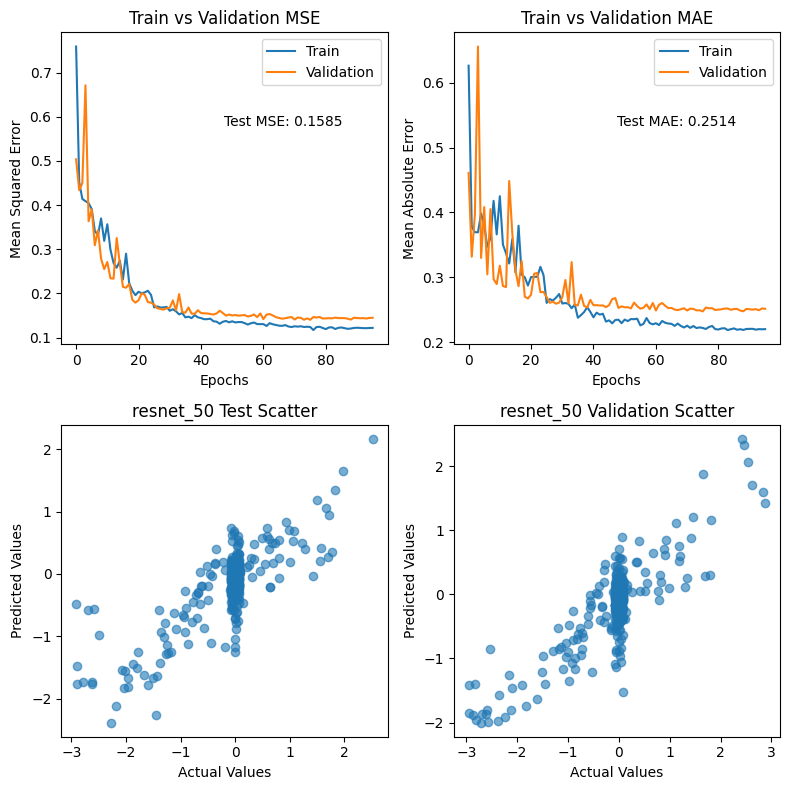

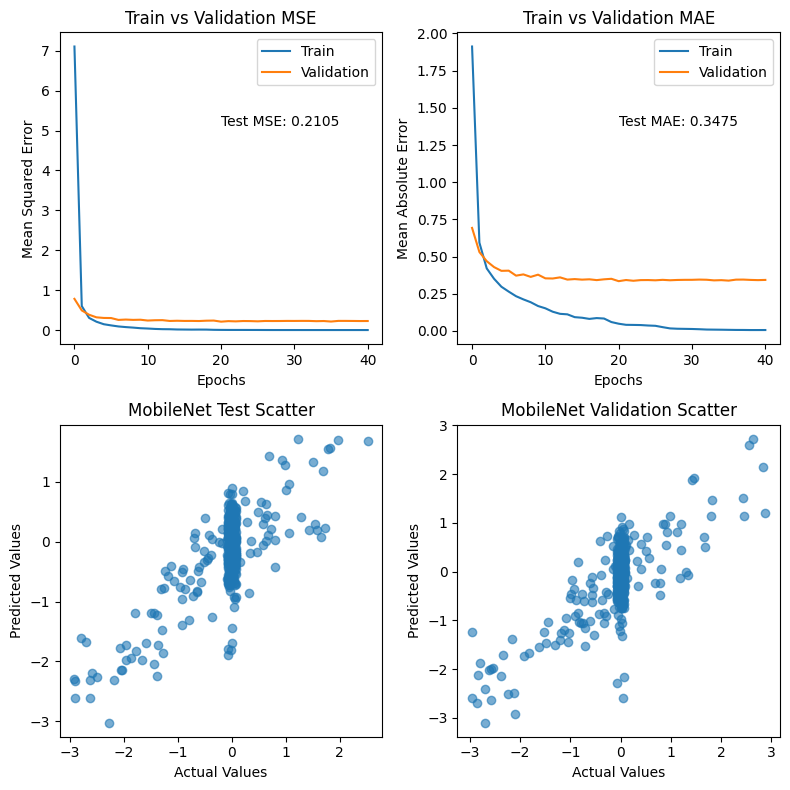

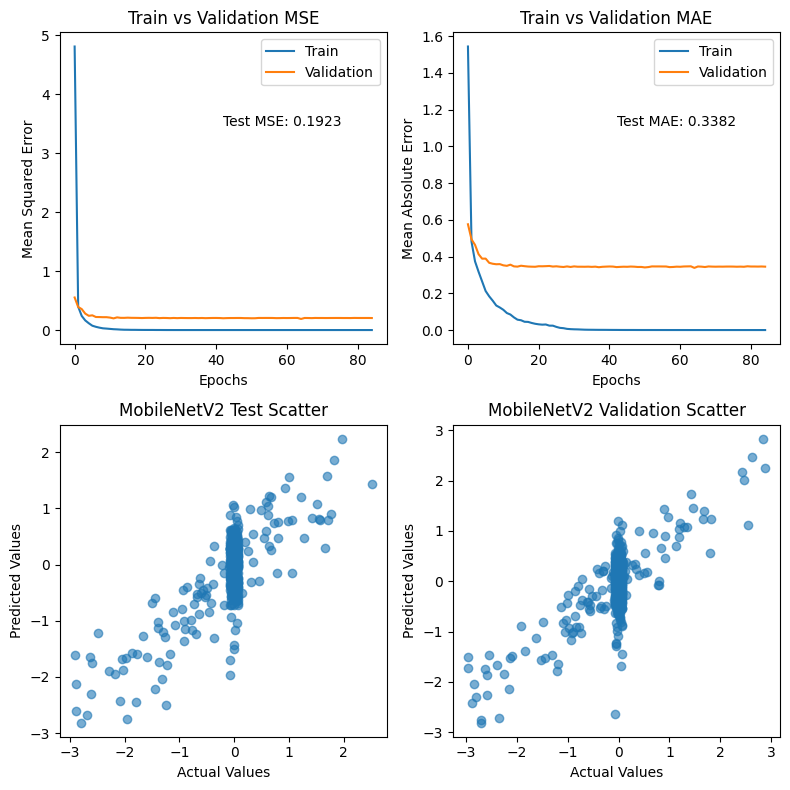

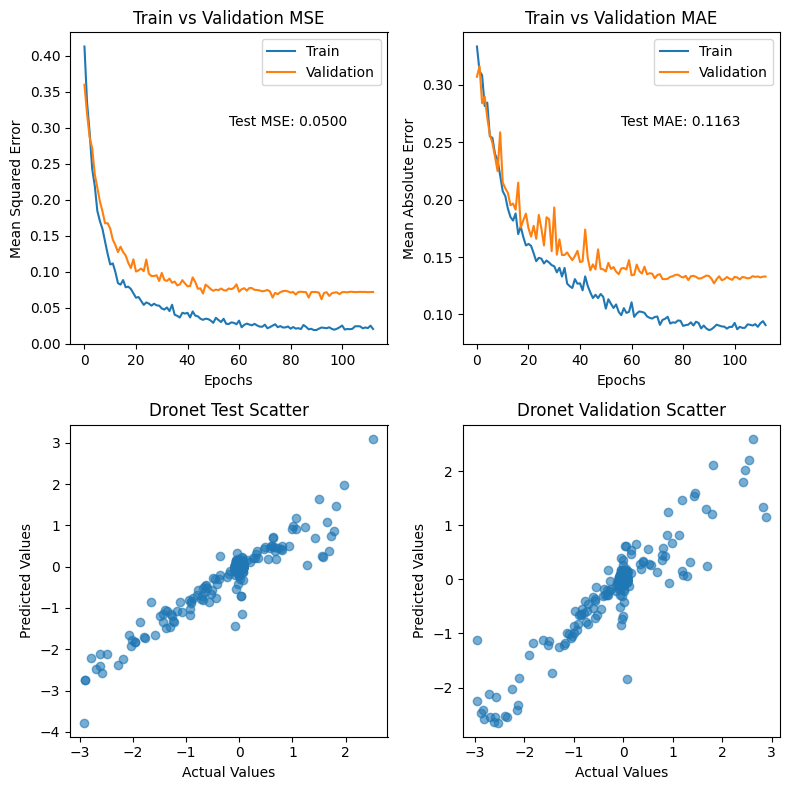

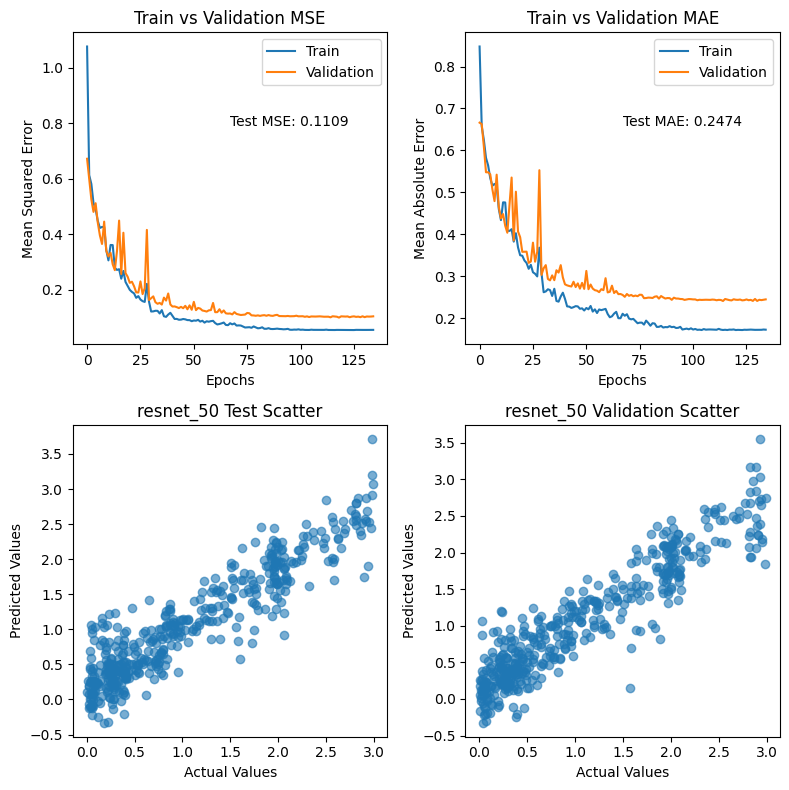

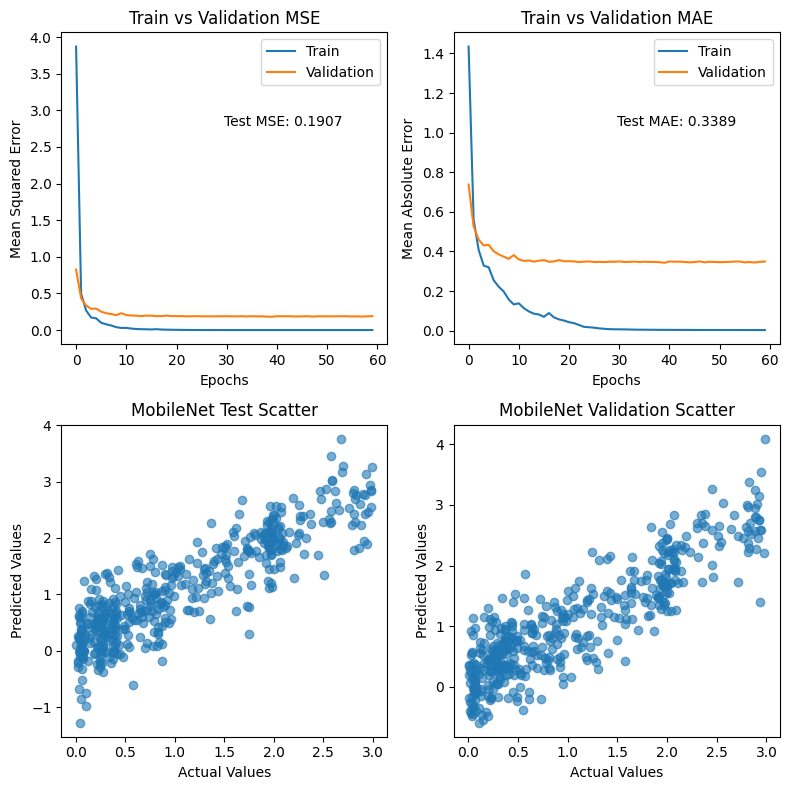

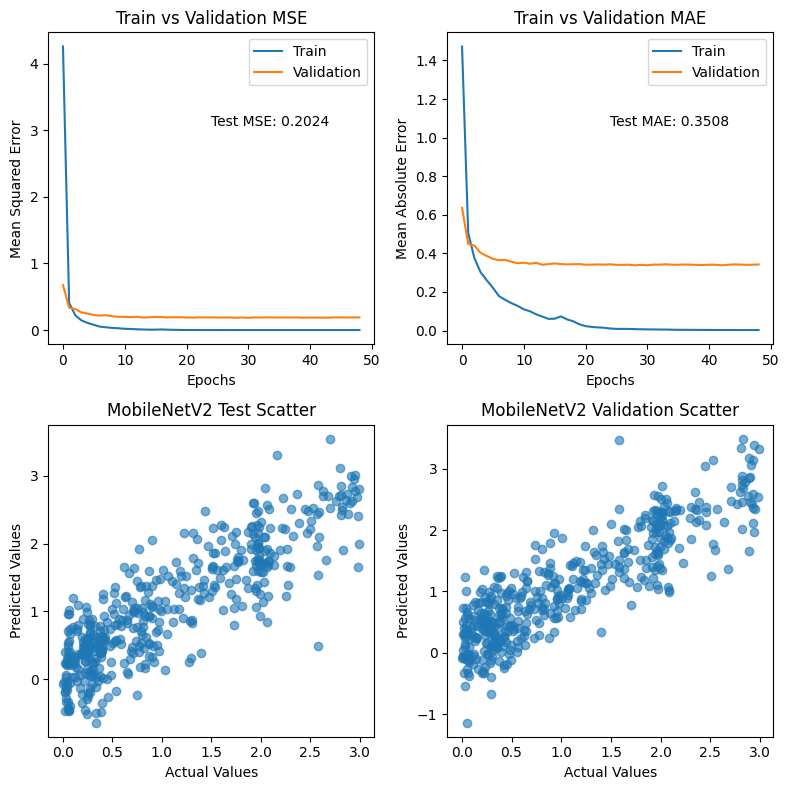

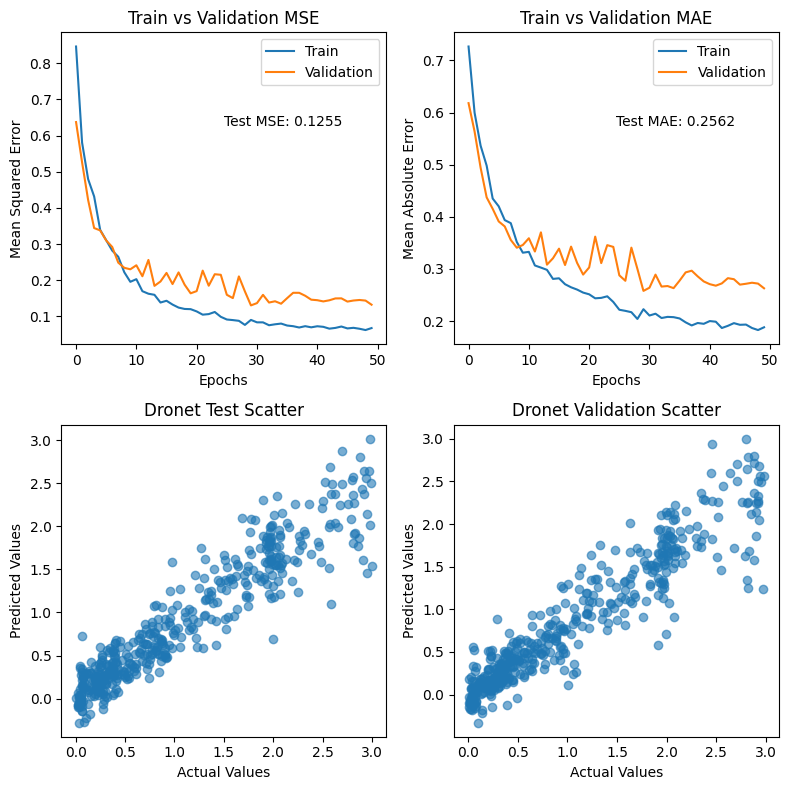

In [9]:
models = {
    "ResNet50": create_resnet50(),
    "MobileNet": create_MobileNet(),
    "MobileNetV2": create_MobileNetV2(),
    "Dronet": create_dronet(),
}

evaluate_x_axis_results(models["ResNet50"], DATASET_PATH)
evaluate_x_axis_results(models["MobileNet"], DATASET_PATH)
evaluate_x_axis_results(models["MobileNetV2"], DATASET_PATH)
evaluate_x_axis_results(models["Dronet"], DATASET_PATH)

models = {
    "ResNet50": create_resnet50(),
    "MobileNet": create_MobileNet(),
    "MobileNetV2": create_MobileNetV2(),
    "Dronet": create_dronet(),
}

evaluate_y_axis_results(models["ResNet50"], DATASET_PATH)
evaluate_y_axis_results(models["MobileNet"], DATASET_PATH)
evaluate_y_axis_results(models["MobileNetV2"], DATASET_PATH)
evaluate_y_axis_results(models["Dronet"], DATASET_PATH)